In [1]:
from template_configurations.qiskit.pulse_level.pulse_config import (
    q_env_config as pulse_q_env_config,
)

%matplotlib inline

/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'x', 'tdg', 'id', 'delay', 's', 'rz', 'measure', 't', 'sdg', 'reset', 'z', 'sx', 'h'}
  q1: {'x', 'tdg', 'id', 'delay', 's', 'rz', 'measure', 't', 'sdg', 'reset', 'z', 'sx', 'h'}
  q2: {'x', 'tdg', 'id', 'delay', 's', 'rz', 'measure', 't', 'sdg', 'reset', 'z', 'sx', 'h'}
  q3: {'x', 'tdg', 'id', 'delay', 's', 'rz', 'measure', 't', 'sdg', 'reset', 'z', 'sx', 'h'}
  q4: {'tdg', 'id', 'delay', 's', 'rz', 'measure', 't', 'sdg', 'reset', 'z', 'h'}
  q5: {'tdg', 'id', 'delay', 's', 'rz', 'measure', 't', 'sdg', 'reset', 'z', 'h'}
  q6: {'tdg', 'id', 'delay', 's', 'rz', 'measure', 't', 'sdg', 'reset', 'z', 'h'}
Multi qubit instructions:
  (0, 1): {'ecr', 'cr45p', 'cr45m'}
  (1, 0): {'ecr', 'cr45p', 'cr45m'}
  (1, 2): {'ecr', 'cr45p', 'cr45m'}
  (1, 3): {'ecr', 'cr45p', 'cr45m'}
)>
Circuit context:                 ┌───┐┌─────┐     ┌──────┐┌───┐
      q_0 -> 0 ┤ H ├┤ Sdg ├─────

In [2]:
from quantumenvironment import QuantumEnvironment
from context_aware_quantum_environment import ContextAwareQuantumEnvironment
from gymnasium.wrappers import RescaleAction, ClipAction
from helper_functions import perform_standard_calibrations

In [3]:
q_env = QuantumEnvironment(pulse_q_env_config)
from qiskit.primitives import Estimator

# q_env = ContextAwareQuantumEnvironment(
#     gate_q_env_config, circuit_context, training_steps_per_gate=250
# )
# q_env.estimator = Estimator()
q_env = ClipAction(q_env)
q_env = RescaleAction(q_env, -1.0, 1.0)

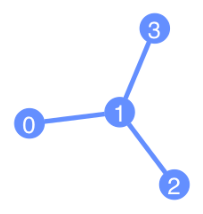

In [4]:
from qiskit.visualization import plot_gate_map

# print("Subsystem dims", q_env.backend.options.subsystem_dims)
plot_gate_map(q_env.backend)

In [5]:
from qiskit.circuit import QuantumCircuit
from helper_functions import simulate_pulse_schedule
from qiskit.quantum_info import Operator, Statevector
from qiskit import pulse
import numpy as np

print(q_env.backend.options.subsystem_dims)
cal_h0 = q_env.backend.target.get_calibration("h", (0,))
cal_h1 = q_env.backend.target.get_calibration("h", (1,))
cal_x0 = q_env.backend.target.get_calibration("x", (0,))
cal_x1 = q_env.backend.target.get_calibration("x", (1,))
with pulse.build(backend=q_env.backend) as cal:
    # pulse.call(cal_x0)
    pulse.call(cal_h0)
    pulse.call(cal_h1)

results = simulate_pulse_schedule(
    q_env.backend,
    cal,
    target_unitary=Operator.from_label("HH"),
    target_state=Statevector.from_label("++"),
)
print("State fidelity", results["state_fidelity"])
print("Gate fidelity", results["gate_fidelity"])
np.round(results["projected_unitary"].data, 2)

[3, 3, 1, 1, 1, 1, 1]
State fidelity 0.9999063464360084
Gate fidelity 0.200003783928865


array([[ 0.5 +0.j  , -0.5 +0.j  , -0.5 +0.j  ,  0.5 -0.02j],
       [ 0.5 -0.j  ,  0.51-0.01j, -0.5 +0.01j, -0.49+0.02j],
       [ 0.5 -0.01j, -0.5 +0.02j,  0.49-0.01j, -0.5 +0.03j],
       [ 0.5 -0.j  ,  0.49-0.02j,  0.5 -0.01j,  0.5 -0.03j]])

In [6]:
import yaml

with open(
        "/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/template_configurations/agent_config.yaml",
        "r",
) as f:
    agent_config = yaml.safe_load(f)

In [7]:
from ppo import make_train_ppo, CustomPPO

ppo_agent = CustomPPO(agent_config, q_env)

/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


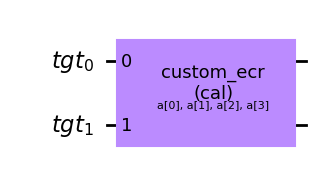

In [8]:
q_env.circuit_truncations[0].draw("mpl")

In [9]:
ppo_agent.train(
    total_updates=300, print_debug=False, num_prints=40, clear_history=False
)

  0%|          | 0/300 [00:00<?, ?it/s]

Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'YI', 'YZ'],
              coeffs=[ 0.5+0.j, -0.5+0.j,  0.5+0.j, -0.5+0.j])
Time to run simulation:  12.054927825927734


  0%|          | 1/300 [00:14<1:10:08, 14.08s/it]

Finished Estimator job
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'YI', 'YZ'],
              coeffs=[ 0.5+0.j, -0.5+0.j, -0.5+0.j,  0.5+0.j])
Time to run simulation:  11.107215166091919


  1%|          | 2/300 [00:26<1:04:37, 13.01s/it]

Finished Estimator job
Sending Estimator job...
SparsePauliOp(['II', 'XY', 'YX', 'ZZ'],
              coeffs=[ 0.5+0.j, -0.5+0.j,  0.5+0.j, -0.5+0.j])
Time to run simulation:  11.491467714309692


  1%|          | 3/300 [00:42<1:10:46, 14.30s/it]

Finished Estimator job
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j])
Time to run simulation:  10.745199918746948
Finished Estimator job


  1%|▏         | 4/300 [00:54<1:06:17, 13.44s/it]

Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j])


  1%|▏         | 4/300 [00:59<1:13:16, 14.85s/it]


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4
n_epochs = len(mean_rewards)
fidelity_range = np.arange(0, n_epochs - 1, q_env.benchmark_cycle)
plt.plot(mean_rewards / 2, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    fidelity_range,
    np.array(q_env.avg_fidelity_history)[:, 0],
    label="Average Fidelity (mean over batch)",
)
plt.plot(
    fidelity_range,
    np.array(q_env.avg_fidelity_history)[:, 1],
    label="Average Fidelity)",
)
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(f"{q_env.target['gate'].name} Learning Curve")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

plt.plot(q_env.avg_fidelity_history)
plt.show()

In [ ]:
from torch import Tensor

params = ppo_agent.agent(Tensor([0]))
params

In [ ]:
q_env.backend.target.get_calibration("h", (0,))

In [ ]:
from helper_functions import simulate_pulse_schedule

data = simulate_pulse_schedule(
    q_env.backend,
    q_env.backend.target.get_calibration("h", (0,)),
    target_unitary=Operator.from_label("IH"),
    target_state=Statevector.from_label("0+"),
)

data

In [ ]:
data["projected_unitary"].draw("latex")

In [ ]:
Operator(q_env.target["gate"]).draw("latex")

In [ ]:
from qiskit import pulse

with pulse.build(backend=q_env.backend) as cal:
    pulse.call(q_env.backend.target.get_calibration("s", (0,)))
pulse.play(
    pulse.Drag(
        duration=160,
        amp=params[0],
        sigma=40,
        beta=0,
    ),
    pulse.DriveChannel(0),
)
pulse.call(q_env.backend.target.get_calibration("s", (0,)))

data2 = simulate_pulse_schedule(
    q_env.backend,
    cal,
    target_unitary=Operator.from_label("H"),
    target_state=Statevector.from_label("+"),
)

In [ ]:
data2["projected_unitary"].draw("latex")
data2